## **EDGE SIDE **

In [ ]:
import os
import tensorflow as tf
import numpy as np #adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import pandas as pd #data structures and operations for manipulating numerical tables and time series
import sys # system path io
import glob #glob module is used to retrieve files/pathnames matching a specified pattern
from tqdm import tqdm # show progress bar when a loop is running
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import tools
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis
init_notebook_mode()
import matplotlib.pyplot as plt
from matplotlib import patches as patches
from pathlib import Path
import xml.etree.ElementTree as ET
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from keras.applications.mobilenet import MobileNet,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import backend as K
import io
from google.colab import drive
from sklearn.model_selection import KFold, StratifiedKFold,LeaveOneOut
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping
import shutil
import statistics
from keras.models import Model
from tensorflow.keras import layers
drive.mount('/content/gdrive')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Structure: Diagnosis, Triage_Level
#NEED TO CODE FOR THE ZERO TRIAGE SCORE!
#Not real scores!
LookUp_Dictionary  = {
  'burns1':1,
  'burns2': 2,
  'burns3':10 ,
  'BacterialInfections': 5, 
  'NailDiseases':2 ,
  'ContactDermatitis':6,
  'UrticariaHives':3,
  'Others':0,
  'wounds': 7,
  'ViralInfections':5
}
print(LookUp_Dictionary)

{'burns1': 1, 'burns2': 2, 'burns3': 10, 'BacterialInfections': 5, 'NailDiseases': 2, 'ContactDermatitis': 6, 'UrticariaHives': 3, 'Others': 0, 'wounds': 7, 'ViralInfections': 5}


In [ ]:
IMAGE_SIZE=[250,250]
batch_size=32
NN =  MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) 
#MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)   
for layer in NN.layers:
    layer.trainable = False
# layers creation - Here more can be added
x = layers.Flatten()(NN.output)
x = layers.Dense(1000, activation='relu')(x)
prediction = layers.Dense(10, activation='softmax')(x)
# creating a model object
model = Model(inputs=NN.input, outputs=prediction)
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
  loss='categorical_crossentropy',

  optimizer='sgd',

  metrics=['accuracy'] 

)

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
import PIL
X=[]
Y=[]
base_dir="/content/gdrive/MyDrive/MBZUAI/Smart Triage/Potential Datasets/SkinBurns"
labels_list=['burns2','burns1','burns3','BacterialInfections', 'NailDiseases','ContactDermatitis','UrticariaHives','Others','wounds','ViralInfections']
dir=os.getcwd()
for directory in labels_list:
    print(directory)
    #print(len(os.listdir(base_dir+'/'+directory)))
    for files in os.listdir(base_dir+'/'+directory):
        #img = Image.open(directory+'/'+files)
        #img = img.convert('L')
        #img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        X.append(directory+'/'+files)
        #X.append([np.array(img)])
        current_index=labels_list.index(directory)
        Y.append(current_index)
X=np.asarray(X)
Y=np.asarray(Y)

burns2
burns1
burns3
BacterialInfections
NailDiseases
ContactDermatitis
UrticariaHives
Others
wounds
ViralInfections


In [ ]:
!mkdir  validation
!mkdir  validation/burns2
!mkdir  validation/burns1
!mkdir  validation/burns3
!mkdir  validation/BacterialInfections
!mkdir  validation/NailDiseases
!mkdir  validation/ContactDermatitis
!mkdir  validation/UrticariaHives
!mkdir  validation/Others
!mkdir  validation/wounds
!mkdir  validation/ViralInfections

In [ ]:
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []

validation_path="validation"
train_path= '/content/gdrive/MyDrive/MBZUAI/Smart Triage/Potential Datasets/SkinBurns/'
#skf = StratifiedKFold(n_splits=2, shuffle=True)
#skf.get_n_splits(X, Y)
accuracy_list= list()
precision_list=list()
f1_list=list()
microprecision_list=list()
microf1_list=list()
means, mins, maxs = list(),list(),list()
f1means, f1mins, f1maxs = list(),list(),list()
microf1means, microf1mins, microf1maxs = list(),list(),list()
precmeans, precmins, precmaxs = list(),list(),list()
microprecmeans, microprecmins, microprecmaxs = list(),list(),list()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7,min_delta=.001,mode='auto')
foldNum=0
k=5
skf = StratifiedKFold(n_splits=k, shuffle=True)

for train_index, val_index in skf.split(X, Y):
             
       foldNum+=1
       model.compile(loss='categorical_crossentropy', optimizer='sgd',  metrics=['accuracy'] )
       print("Results for fold",foldNum)
       X_train, X_val = X[train_index], X[val_index]
       Y_train, Y_val = Y[train_index], Y[val_index]
       for eachindex in range(len(X_val)):
           shutil.move('/content/gdrive/MyDrive/MBZUAI/Smart Triage/Potential Datasets/SkinBurns/'+X_val[eachindex], 
                    'validation/'+X_val[eachindex])
       
       #Start ImageClassification Model
       train_datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True,  vertical_flip=True, brightness_range=[0.7,1.2], preprocessing_function=preprocess_input)

       validation_datagen = ImageDataGenerator( preprocessing_function=preprocess_input)
       train_generator = train_datagen.flow_from_directory(
            train_path,
            shuffle= True,
            target_size=IMAGE_SIZE,
            batch_size=32,
            subset='training')
       validation_generator = validation_datagen.flow_from_directory(
            validation_path,
            target_size=IMAGE_SIZE,
            batch_size=32,
            shuffle=False)  
       
       #history=
       model.fit(train_generator, 
                        epochs=40,
                        validation_data = validation_generator,
                        steps_per_epoch=int(len(X_train) // batch_size),
                        validation_steps=int(len(X_val) // batch_size),
                        callbacks=[callback])
       predictions = model.predict(validation_generator, verbose=1)
       #score = model.evaluate(validation_generator,batch_size =32)
       #print('eval', score)
       yPredictions = np.argmax(predictions, axis=1)
       true_classes = validation_generator.classes
       # evaluate validation performance
       #print("***Performance on Validation data***")
       accuracy=accuracy_score(true_classes, yPredictions)
       f1=f1_score(true_classes, yPredictions,average='macro')
       microf1= f1_score(true_classes, yPredictions,average='micro')
       precision= precision_score(true_classes, yPredictions,average='macro')
       microprecision= precision_score(true_classes, yPredictions,average='micro')
       #precision=precision_score(true_classes, yPredictions,average='weighted')
       #f1Score=f1_score(true_classes, yPredictions, average='weighted') 
       #print("Accuracy  : {}".format(accuracy))
       #print("Precision : {}".format(precision))
       #print("f1Score : {}".format(f1Score))
       #cm=confusion_matrix(true_classes, yPredictions)
       accuracy_list.append(accuracy)
       f1_list.append(f1)
       precision_list.append(precision)
       microf1_list.append(microf1)
       microprecision_list.append(microprecision)
       #print(cm)
       #valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)
       for returnindex in range(len(X_val)):
            shutil.move('validation/'+X_val[returnindex],'/content/gdrive/MyDrive/MBZUAI/Smart Triage/Potential Datasets/SkinBurns/'+X_val[returnindex])
#gotta change this to F1
k_mean=statistics.mean(accuracy_list)
k_max=max(accuracy_list)
k_min=min(accuracy_list)
means.append(k_mean)
mins.append(k_mean - k_min)
maxs.append(k_max - k_mean)
#==================
f1_mean=statistics.mean(f1_list)
f1_max=max(f1_list)
f1_min=min(f1_list)
f1means.append(f1_mean)
f1mins.append(f1_mean - f1_min)
f1maxs.append(f1_max - f1_mean)
#========================
prec_mean=statistics.mean(precision_list)
prec_max=max(precision_list)
prec_min=min(precision_list)
precmeans.append(prec_mean)
precmins.append(prec_mean - prec_min)
precmaxs.append(prec_max - prec_mean)
#==========================
microprec_mean=statistics.mean(microprecision_list)
microprec_max=max(microprecision_list)
microprec_min=min(microprecision_list)
microprecmeans.append(microprec_mean)
microprecmins.append(microprec_mean - microprec_min)
microprecmaxs.append(microprec_max - microprec_mean)
#===========================
microf1_mean=statistics.mean(microf1_list)
microf1_max=max(microf1_list)
microf1_min=min(microf1_list)
microf1means.append(microf1_mean)
microf1mins.append(microf1_mean - microf1_min)
microf1maxs.append(microf1_max - microf1_mean)

print('Image_size and batch_size')
print(IMAGE_SIZE,batch_size)
print('Minimum Accuracy')
print(mins)
print('Maximum Accuracy')
print(maxs)
print('Average Accuracy')
print(means)
#=============
print('Minimum macro precision')
print(precmins)
print('Maximum macro precision')
print(precmaxs)
print('Average macro precision')
print(precmeans)
#===============
print('Minimum macro F1')
print(f1mins)
print('Maximum macro F1')
print(f1maxs)
print('Average macro F1')
print(f1means)
#===============
print('Minimum micro precision')
print(microprecmins)
print('Maximum micro precision')
print(microprecmaxs)
print('Average micro precision')
print(microprecmeans)
#===============
print('Minimum micro F1')
print(microf1mins)
print('Maximum micro F1')
print(microf1maxs)
print('Average micro F1')
print(microf1means)
#plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
#plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
#plt.show()
   #model.fit_generator(train_generator, epochs=50,  verbose = 0, validation_data=test_generator)

   #scores = model.evaluate(X[test], Y[test], verbose=0)
   #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))




Results for fold 1
Found 3083 images belonging to 10 classes.
Found 770 images belonging to 10 classes.
Epoch 1/40
96/96 [==============================] - 74s 748ms/step - loss: 0.0785 - accuracy: 0.9757 - val_loss: 0.0823 - val_accuracy: 0.9818
Epoch 2/40
96/96 [==============================] - 70s 735ms/step - loss: 0.0721 - accuracy: 0.9751 - val_loss: 0.0963 - val_accuracy: 0.9701
Epoch 3/40
96/96 [==============================] - 70s 730ms/step - loss: 0.0691 - accuracy: 0.9780 - val_loss: 0.0979 - val_accuracy: 0.9714
Epoch 4/40
96/96 [==============================] - 71s 735ms/step - loss: 0.0606 - accuracy: 0.9807 - val_loss: 0.2220 - val_accuracy: 0.9232
Epoch 5/40
96/96 [==============================] - 70s 732ms/step - loss: 0.0540 - accuracy: 0.9833 - val_loss: 0.0964 - val_accuracy: 0.9753
Epoch 6/40
96/96 [==============================] - 71s 742ms/step - loss: 0.0548 - accuracy: 0.9831 - val_loss: 0.1165 - val_accuracy: 0.9596
Epoch 7/40
96/96 [====================

Image_size and batch_size
[250, 250] 32
Minimum Accuracy
[0.01092521693659032]
Maximum Accuracy
[0.008555302543929222]
Average Accuracy
[0.9771589831703565]
Minimum macro precision
[0.008642446502106105]
Maximum macro precision
[0.011319645810114132]
Average macro precision
[0.9813430436916845]
Minimum macro F1
[0.008391491584136324]
Maximum macro F1
[0.00855679484035754]
Average macro F1
[0.9787656759044436]
Minimum micro precision
[0.01092521693659032]
Maximum micro precision
[0.008555302543929222]
Average micro precision
[0.9771589831703565]
Minimum micro F1
[0.01092521693659032]
Maximum micro F1
[0.008555302543929222]
Average micro F1
[0.9771589831703565]

# **HERE RETRAIN THE MODEL ON THE ENTIRE DATASET **

In [ ]:
####retrain on the entire dataset
IMAGE_SIZE=[250,250]
entire_datasetNN =  MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)  # do not include head, transfer learning
for layer in entire_datasetNN.layers:
    layer.trainable = False
# layers creation - Here more can be added
xlayers = layers.Flatten()(entire_datasetNN.output)
xlayers = layers.Dense(1000, activation='relu')(xlayers)
Alldataprediction = layers.Dense(10, activation='softmax')(xlayers)
# creating a model object
alldatamodel = Model(inputs=entire_datasetNN.input, outputs=Alldataprediction)
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
alldatamodel.compile(
  loss='categorical_crossentropy',

  optimizer='sgd',

  metrics=['accuracy'] 

)


9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:

Alldatatrain_path= '/content/gdrive/MyDrive/MBZUAI/Smart Triage/Potential Datasets/SkinBurns/'
Alldatavalidation_path= '/content/gdrive/MyDrive/MBZUAI/Smart Triage/Potential Datasets/SkinBurns/'
#FIX THIS !!
###################
#image_files = glob(training_images_url + '/*/*.png')
#datasize = image_files.extend(glob(Alldatatrain_path + '/*/*.jp*g'))
datasize=3853
###################
batch_size=32
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=.001,patience=7,mode='auto')
alldatatrain_datagen  = ImageDataGenerator(rotation_range=20, horizontal_flip=True,  vertical_flip=True, brightness_range=[0.7,1.2], preprocessing_function=preprocess_input)

alldatavalidation_datagen = ImageDataGenerator( preprocessing_function=preprocess_input)
#Start ImageClassification Model
alldatatrain_generator = alldatatrain_datagen.flow_from_directory(
            Alldatatrain_path,
            shuffle= True,
            target_size=IMAGE_SIZE,
            batch_size=32)
alldatavalidation_generator = alldatavalidation_datagen.flow_from_directory(
            Alldatavalidation_path,
            target_size=IMAGE_SIZE,
            batch_size=32,
            shuffle=False)  
       
history=alldatamodel.fit(alldatatrain_generator, 
                        epochs=40,                       
                        validation_data = alldatavalidation_generator,
                        steps_per_epoch=int(datasize // batch_size),
                        validation_steps=int(datasize // batch_size),    
                        callbacks=[callback])

Found 3853 images belonging to 10 classes.
Found 3853 images belonging to 10 classes.


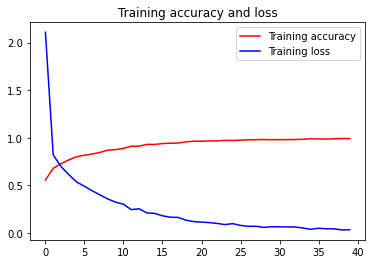

<Figure size 432x288 with 0 Axes>

In [ ]:
###save the model 
###plot the graphs

entire_datasetNN.save('MBZUAITriage.h5')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training accuracy and loss')
plt.legend(loc=0)
plt.figure()


plt.show()

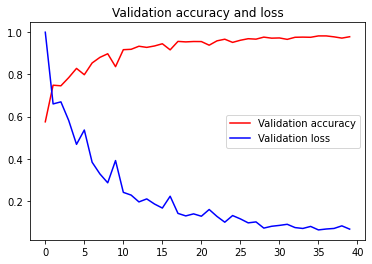

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Validation accuracy and loss')
plt.legend(loc=0)
plt.figure()
plt.show()

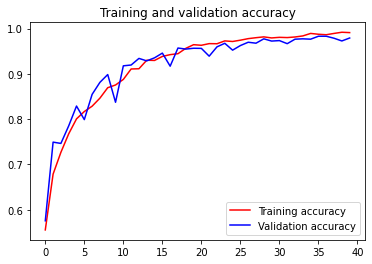

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

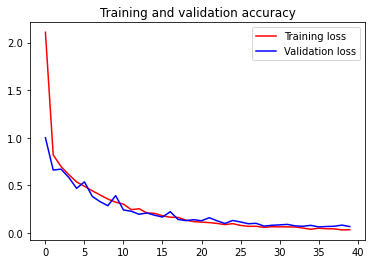

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
###get all the metrics 
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
alldatapredictions = alldatamodel.predict(alldatavalidation_generator, verbose=1)
alldatayPredictions = np.argmax(alldatapredictions, axis=1)
alldatatrue_classes = alldatavalidation_generator.classes

KeyboardInterrupt: ignored

In [ ]:
alldataaccuracy= accuracy_score(alldatatrue_classes, alldatayPredictions)
Macroalldataf1=f1_score(alldatatrue_classes, alldatayPredictions,average='macro')
Microalldataf1=f1_score(alldatatrue_classes, alldatayPredictions,average='micro')
Macroalldataprecision=precision_score(alldatatrue_classes, alldatayPredictions,average='macro')
Microalldataprecision=precision_score(alldatatrue_classes, alldatayPredictions,average='micro')
print('Accuracy' ,alldataaccuracy)
print('Macro f1' ,Macroalldataf1)
print('Micro f1' ,Microalldataf1)
print('Macro precision' ,Macroalldataprecision)
print('Micro precision' ,Microalldataprecision)
alldataCM= confusion_matrix(alldatatrue_classes, alldatayPredictions)
print(alldataCM)

Accuracy 0.9792369582143784
Macro f1 0.9799647245179463
Micro f1 0.9792369582143784
Macro precision 0.9824407463753726
Micro precision 0.9792369582143784
[[ 478    1    0    0    0   20    0    0    0    0]
 [   1  371    0    0    4   29    0    0    0    0]
 [   0    0  798    0    0    0    0    0    0    0]
 [   0    0    0   49    0    0    0    0    0    0]
 [   0    0    0    0  267    4    0    0    0    0]
 [   2    4    4    0    2 1429    0    0    0    0]
 [   0    0    0    0    0    0   59    0    0    0]
 [   0    0    0    0    1    1    4  147    1    0]
 [   0    0    0    0    0    0    0    2   81    0]
 [   0    0    0    0    0    0    0    0    0   94]]


Accuracy 0.9792369582143784
Macro f1 0.9799647245179463
Micro f1 0.9792369582143784
Macro precision 0.9824407463753726
Micro precision 0.9792369582143784
[[ 478    1    0    0    0   20    0    0    0    0]
 [   1  371    0    0    4   29    0    0    0    0]
 [   0    0  798    0    0    0    0    0    0    0]
 [   0    0    0   49    0    0    0    0    0    0]
 [   0    0    0    0  267    4    0    0    0    0]
 [   2    4    4    0    2 1429    0    0    0    0]
 [   0    0    0    0    0    0   59    0    0    0]
 [   0    0    0    0    1    1    4  147    1    0]
 [   0    0    0    0    0    0    0    2   81    0]
 [   0    0    0    0    0    0    0    0    0   94]]

In [ ]:
# Add some structure for the Look up table (diagnosis , triage score) (key is? better use the name, the training index is not fixed)
# need to pipe the output 

import numpy as np
from google.colab import files
from keras.preprocessing import image
print(alldatatrain_generator.class_indices)
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  
  path = fn
  img = image.load_img(path, target_size=(250, 250))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = alldatamodel.predict(images, batch_size=10)
  #print(fn)
  print(classes.argmax())
  Diagnosis= dict((v,k) for k,v in alldatatrain_generator.class_indices.items()).get(classes.argmax())
  print(Diagnosis)
  #https://www.ontario.ca/page/time-spent-emergency-department#urgency
  print('Urgency Level')
  print(LookUp_Dictionary.get(Diagnosis))

{'BacterialInfections': 0, 'ContactDermatitis': 1, 'NailDiseases': 2, 'Others': 3, 'UrticariaHives': 4, 'ViralInfections': 5, 'burns1': 6, 'burns2': 7, 'burns3': 8, 'wounds': 9}


Saving 0722.JPG to 0722.JPG
5
ViralInfections
Triage Score
5


In [ ]:
entire_datasetNN.load_weights('/content/gdrive/MyDrive/MBZUAI/Smart Triage/Potential Datasets/MBZUAITriage.h5')

from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
alldatapredictions = alldatamodel.predict(alldatavalidation_generator, verbose=1)
alldatayPredictions = np.argmax(alldatapredictions, axis=1)
alldatatrue_classes = alldatavalidation_generator.classes

alldataaccuracy= accuracy_score(alldatatrue_classes, alldatayPredictions)
Macroalldataf1=f1_score(alldatatrue_classes, alldatayPredictions,average='macro')
Microalldataf1=f1_score(alldatatrue_classes, alldatayPredictions,average='micro')
Macroalldataprecision=precision_score(alldatatrue_classes, alldatayPredictions,average='macro')
Microalldataprecision=precision_score(alldatatrue_classes, alldatayPredictions,average='micro')


121/121 [==============================] - 39s 321ms/step


In [ ]:
frameperrsecond= int(3853/39)
print(frameperrsecond)

98


1.6333333333333333

In [ ]:
!nvidia-smi

Fri Mar 11 22:04:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    33W / 250W |   4683MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------